##  Project Info:

In this project a newspaper's website was scraped to get data about their headlines.<br>
AWS Translate and Comprehend are used to do a Sentiment Analysis on the obtained data. <br>


---

In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import boto3
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [1]:
def scrape_articles(url):
    # Send an HTTP GET request to the provided URL
    response = requests.get(url)

    # Initialize an empty dictionary to store the articles
    articles_dict = {}

    # Check if the request was successful
    if response.status_code == 200:
        # Parse the HTML content with BeautifulSoup
        soup = BeautifulSoup(response.text, 'html.parser')

        # Find all the article elements
        articles = soup.find_all('article')

        # Iterate through each article and extract the desired information
        for article in articles:
            article_id = article['data-id']
            headline = article.find('h2').find('a').text.strip()
            article_link = article.find('h2').find('a')['href']
            time = article.find('time')['datetime']
            description = article.find('p').text.strip()
            comments = article.find('span', class_='comments').text
            favorites = article.find('span', class_='fav').text
            bookmarks = article.find('span', class_='bookmark').text

            # Store the article information in a dictionary
            article_info = {
                "headline": headline,
                "article_link": article_link,
                "time": time,
                "description": description,
                "comments": comments,
                "favorites": favorites,
                "bookmarks": bookmarks
            }

            # Add the article info to the articles_dict using article_id as the key
            articles_dict[article_id] = article_info

    else:
        print(f"Failed to retrieve the page. Status code: {response.status_code}")

    return articles_dict



In [2]:
# List of URLs
urls = [f"https://www.skai.gr/news/greece?page={i}" for i in range(1, 40)]

# Initialize an empty dictionary to store all articles
all_articles = {}

# Loop through the URLs and scrape articles
for url in urls:
    articles_dict = scrape_articles(url)
    all_articles.update(articles_dict)

# Now 'all_articles' contains articles from all the provided URLs
df = pd.DataFrame(all_articles).transpose()[['headline','time']]
df['time'] = pd.to_datetime(df['time'])
df.set_index('time',inplace=True)

In [30]:
# Create session with credentials
session = boto3.Session(
    aws_access_key_id='AWS_ACCESS_KEY_ID',
    aws_secret_access_key='AWS_SECRET_ACCESS_KEY',
    region_name='REGION'
)

# Create an AWS Translate client
translate = session.client('translate')  # Change the region to your desired region

# Function to translate text using AWS Translate
def translate_text(text, target_language_code):
    response = translate.translate_text(
        Text=text,
        SourceLanguageCode="el",
        TargetLanguageCode=target_language_code
    )
    return response['TranslatedText']

# Iterate over the DataFrame and translate each cell

df['english_headline'] = df['headline'].apply(lambda text: translate_text(text, "en"))

# Display the translated DataFrame
df.head()

,headline,english_headline
time,,
2023-10-17 10:49:22+03:00,Άντρας 52 ετών παρακολουθούσε παιδάκια σε πισί...,52-year-old man watched children in Heraklion ...
2023-10-17 10:38:05+03:00,Συνελήφθη 81χρονος στη Θεσσαλονίκη καταζητούμε...,81-year-old arrested in Thessaloniki wanted fo...
2023-10-17 10:22:40+03:00,ΔΥΠΑ: Νέος κύκλος κατάρτισης για 30.000 ανέργο...,"IFRA: New training cycle for 30,000 unemployed..."
2023-10-17 10:17:09+03:00,Άνδρας εντοπίστηκε νεκρός σε βάρκα με 38 αλλοδ...,Man found dead on boat with 38 foreigners near...
2023-10-17 09:41:42+03:00,Ληστεία σε ζαχαροπλαστείο στο Πέραμα- Έδεσαν τ...,Robbery at a pastry shop in Perama - They tied...


In [ ]:
# Create an AWS Comprehend
comprehend = session.client('comprehend')

# Function to analyze sentiment using AWS Comprehend
def analyze_sentiment(text):
    sentiment_response = comprehend.detect_sentiment(Text=text, LanguageCode='en')
    return sentiment_response['Sentiment']

# Apply the analyze_sentiment function to the 'TextColumn'
df['Sentiment'] = df['english_headline'].apply(analyze_sentiment)


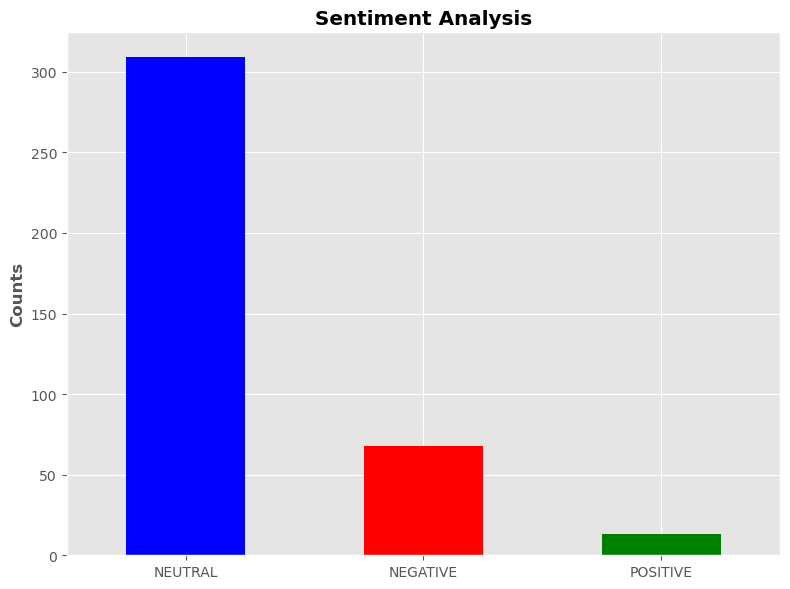

In [15]:
value_counts = df['Sentiment'].value_counts()

# Define colors for each category
colors = ['blue', 'red', 'green']

# Create a bar plot with custom colors
ax = value_counts.plot(kind='bar', color=colors , figsize=(8, 6),rot=0)

# Set the title text and adjust its properties
title = ax.set_title("Sentiment Analysis")
title.set_fontweight('bold')

ax.set_xlabel('')
ax.set_ylabel('Counts', fontdict={'fontweight':'bold'})
plt.tight_layout()
# Show the plot
plt.show()

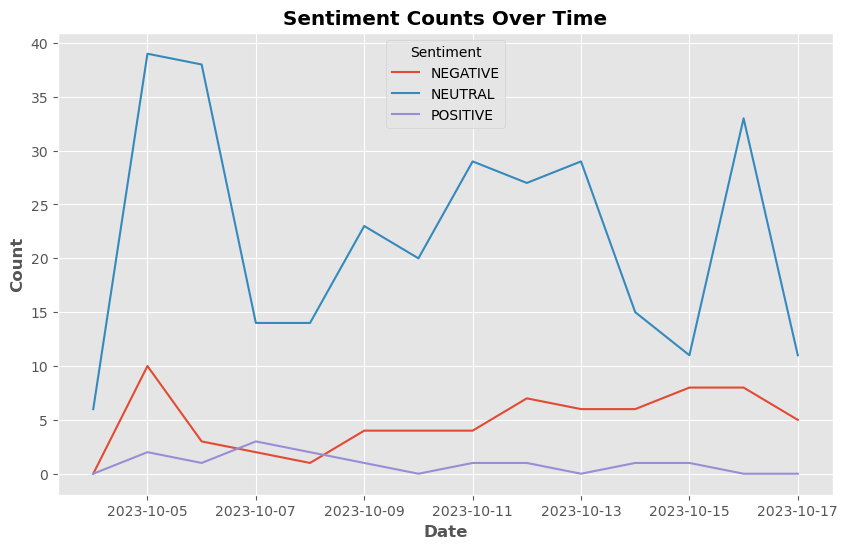

In [13]:
# Group the data by date and calculate sentiment counts
sentiment_counts = df['Sentiment'].groupby(df.index.date).value_counts().unstack(fill_value=0)

plt.figure(figsize=(10, 6))
plt.plot(sentiment_counts,label=sentiment_counts.columns)
# Create a line chart

# sentiment_counts.plot(kind='line', marker='o')
plt.title('Sentiment Counts Over Time', fontdict={'fontweight':'bold'})
plt.xlabel('Date', fontdict={'fontweight':'bold'})
plt.ylabel('Count', fontdict={'fontweight':'bold'})

plt.legend( title='Sentiment', loc=0)
# Show the line chart
plt.show()